In [44]:
# !pip install statannotations

In [25]:
# !pip install japanize-matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np
import io
import japanize_matplotlib
from statsmodels.stats.contingency_tables import Table

In [26]:
data0 = pd.read_csv("/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/data/AllData_aftermapping.csv")
data0.head()

,No_All,CGC,date,sex,age_year,age_month,age,abuse_1,abuse,abuse_num,...,wake_up,breakfast,morning_brushing,school,bedtime,night_brushing,TV,game,meal,extra_lesson
0,1,tokyo,2016-10-12,Female,16,3,16.250000,NaN,Parenting Difficulties,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,tokyo,2016-10-12,Female,14,6,14.500000,NaN,Delinquency,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,tokyo,2016-10-12,Female,15,1,15.083333,NaN,Physical Abuse,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,tokyo,2016-10-12,Female,14,5,14.416667,NaN,Emotional Abuse,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,tokyo,2016-10-12,Female,15,10,15.833333,NaN,Neglect,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# 1. Define the logical order for each column
abuse_order = [
    "Physical Abuse", "Neglect", "Emotional Abuse", "Sexual Abuse", "Delinquency", "Parenting Difficulties", "Others"
]

occlusal_order = [
    "Normal Occlusion", "Crowding", "Anterior Crossbite", "Open Bite", 
    "Maxillary Protrusion", "Crossbite", "Others"
]
need_treated_order = ["No Treatment Required", "Treatment Required"]
emergency_order = ["Urgent Treatment Required"]
gingivitis_order = ["No Gingivitis", "Gingivitis"]
oral_clean_order = ["Poor", "Fair", "Good"]
habits_order = [
    "None", "Digit Sucking", "Nail biting", "Tongue Thrusting", 
    "Smoking", "Others"
]

# 2. Convert columns to Categorical with the specified order
# (Replace 'data_noNA_Only1' with your current dataframe variable name if different)
target_df = data0

target_df['abuse'] = pd.Categorical(target_df['abuse'], categories=abuse_order, ordered=True)
target_df['occlusalRelationship'] = pd.Categorical(target_df['occlusalRelationship'], categories=occlusal_order, ordered=True)
target_df['needTOBEtreated'] = pd.Categorical(target_df['needTOBEtreated'], categories=need_treated_order, ordered=True)
target_df['emergency'] = pd.Categorical(target_df['emergency'], categories=emergency_order, ordered=True)
target_df['gingivitis'] = pd.Categorical(target_df['gingivitis'], categories=gingivitis_order, ordered=True)
target_df['OralCleanStatus'] = pd.Categorical(target_df['OralCleanStatus'], categories=oral_clean_order, ordered=True)
target_df['habits'] = pd.Categorical(target_df['habits'], categories=habits_order, ordered=True)

data0 = target_df

print("Columns converted to ordered categories.")

Columns converted to ordered categories.


In [28]:
# Get column names
data0.columns

Index(['No_All', 'CGC', 'date', 'sex', 'age_year', 'age_month', 'age',
       'abuse_1', 'abuse', 'abuse_num', 'U17', 'U16', 'U15', 'U14', 'U13',
       'U12', 'U11', 'U21', 'U22', 'U23', 'U24', 'U25', 'U26', 'U27', 'L37',
       'L36', 'L35', 'L34', 'L33', 'L32', 'L31', 'L41', 'L42', 'L43', 'L44',
       'L45', 'L46', 'L47', 'u55', 'u54', 'u53', 'u52', 'u51', 'u61', 'u62',
       'u63', 'u64', 'u65', 'l75', 'l74', 'l73', 'l72', 'l71', 'l81', 'l82',
       'l83', 'l84', 'l85', 'needTOBEtreated', 'emergency',
       'emergencyInMonths', 'gingivitis', 'occlusalRelationship', 'habits',
       'OralCleanStatus', 'instruction_detail', 'instruction', 'memo',
       'dentists', '\ndental_hygienist', 'wake_up', 'breakfast',
       'morning_brushing', 'school', 'bedtime', 'night_brushing', 'TV', 'game',
       'meal', 'extra_lesson'],
      dtype='object')

In [29]:
# permanent teeth
perm_cols = [
    'U17', 'U16', 'U15', 'U14', 'U13', 'U12', 'U11', 'U21', 'U22', 'U23', 'U24', 'U25', 'U26', 'U27', 
    'L37', 'L36', 'L35', 'L34', 'L33', 'L32', 'L31', 'L41', 'L42', 'L43', 'L44', 'L45', 'L46', 'L47'
]
# baby teeth
baby_cols = [
    'u55', 'u54', 'u53', 'u52', 'u51', 'u61', 'u62', 'u63', 'u64', 'u65', 
    'l75', 'l74', 'l73', 'l72', 'l71', 'l81', 'l82', 'l83', 'l84', 'l85'
]
# all teeth
all_cols = perm_cols + baby_cols

# 部位定義（前歯・奥歯）
perm_front = [c for c in perm_cols if c[-1] in ['1', '2', '3']]
perm_back = [c for c in perm_cols if c[-1] in ['4', '5', '6', '7']]
baby_front = [c for c in baby_cols if c[-1] in ['1', '2', '3']]
baby_back = [c for c in baby_cols if c[-1] in ['4', '5']]

In [ ]:
def calculate_comprehensive_metrics(row):
    """
    基本指標(DMFT等)とリスク指標(UTN等)をまとめて計算し、
    D,M,F,d,m,f の詳細内訳も返す関数
    """
    # 歯列ごとのデータ抽出
    p_teeth = row[perm_cols] # 永久歯
    b_teeth = row[baby_cols] # 乳歯
    all_teeth = pd.concat([p_teeth, b_teeth]) # 全顎
    
    # -------------------------------------------------------
    # A. 個別カウント (D, M, F, d, m, f)
    # ※ D/d には '3:C' と '8:残根' の両方を含めます（未処置のため）
    # -------------------------------------------------------
    # 永久歯 (Permanent)
    Perm_D = (p_teeth == 3).sum() + (p_teeth == 8).sum() # 未処置 + 残根
    Perm_M = (p_teeth == 4).sum()                        # 喪失
    Perm_F = (p_teeth == 1).sum()                        # 処置
    Perm_DMFT = Perm_D + Perm_M + Perm_F
    Perm_DFT = Perm_D + Perm_F
    
    # 乳歯 (Deciduous)
    Baby_d = (b_teeth == 3).sum() + (b_teeth == 8).sum() # 未処置 + 残根
    Baby_m = (b_teeth == 4).sum()                        # 喪失
    Baby_f = (b_teeth == 1).sum()                        # 処置
    Baby_DMFT = Baby_d + Baby_m + Baby_f
    Baby_dft = Baby_d + Baby_f

    # その他のカウント
    count_C0 = (all_teeth == 2).sum()       # 要観察歯(全体)
    count_Trauma = (all_teeth == 7).sum()   # 外傷(全体)
    count_RDT_total = (all_teeth == 8).sum()# 残根(全体)

    # -------------------------------------------------------
    # B. 総合指標 (Summary Indices)
    # -------------------------------------------------------
    # DMFT Index (永久歯 + 乳歯の合計負荷)
    dmft_total_score = (Perm_D + Perm_M + Perm_F) + (Baby_d + Baby_m + Baby_f)

    # DFT Index (永久歯 + 乳歯の合計負荷)
    dft_total_score = (Perm_D + Perm_F) + (Baby_d + Baby_f)
    
    # Present Teeth (現在歯数)
    # 除外: -1(未萌出), 6(先天欠如), 4(喪失) and NA (Missing)
    # ※喪失歯(4)は「過去に虫歯だった」指標ですが、「現在口にある」歯ではないため除きます
    present_teeth = len(all_teeth) - all_teeth.isin([-1, 6, 4]).sum() - all_teeth.isna().sum()
    present_baby_teeth = len(b_teeth) - b_teeth.isin([-1, 6, 4]).sum() - b_teeth.isna().sum()
    present_perm_teeth = len(p_teeth) - p_teeth.isin([-1, 6, 4]).sum() - p_teeth.isna().sum()
    
    # Healthy Rate (健全歯率: 処置も虫歯もない歯 / 現在歯数)
    # 健全(0)のみカウント
    count_sound = (all_teeth == 0).sum()
    if present_teeth > 0:
        healthy_rate = (count_sound / present_teeth) * 100
    else:
        healthy_rate = 0
        
    # Care Index (処置率: F / (D+M+F))
    total_filled = Perm_F + Baby_f
    if dmft_total_score > 0:
        care_index = (total_filled / dmft_total_score) * 100
    else:
        care_index = np.nan # カリエスフリーの場合は計算不可
        
    # -------------------------------------------------------
    # C. ネグレクト・リスク指標 (Risk Metrics)
    # -------------------------------------------------------
    # UTN (未処置う蝕率): (D + d) / (D + d + F + f) ※Mは含めない
    active_decay = Perm_D + Baby_d
    total_experience_present = active_decay + total_filled
    
    if total_experience_present > 0:
        utn_score = (active_decay / total_experience_present) * 100
    else:
        utn_score = 0

    # 結果をSeriesで返す
    return pd.Series({
        # --- 個別カウント ---
        'Perm_D': Perm_D, 'Perm_M': Perm_M, 'Perm_F': Perm_F,
        'Baby_d': Baby_d, 'Baby_m': Baby_m, 'Baby_f': Baby_f,
        'Perm_DMFT': Perm_DMFT,
        'Baby_DMFT': Baby_DMFT,
        'Perm_DFT': Perm_DFT,
        'Baby_dft': Baby_dft,
        
        # --- ユーザー指定の総合指標 ---
        'Present_Teeth': present_teeth,
        'Present_Perm_Teeth': present_perm_teeth,
        'Present_Baby_Teeth': present_baby_teeth,
        'DMFT_Index': dmft_total_score, # 全体のう蝕経験歯数
        'DFT_Index': dft_total_score, # 全体のう蝕+処置歯数

        'Healthy_Rate': round(healthy_rate, 1),
        'C0_Count': count_C0,
        'Care_Index': round(care_index, 1),
        
        # --- 追加のリスク指標 ---
        'Trauma_Count': count_Trauma,   # 外傷数
        'RDT_Count': count_RDT_total,   # 残根数
        'UTN_Score': round(utn_score, 1)# 未処置率(%)
    })

In [31]:
# ==========================================
# 3. 計算とデータフレームへの結合
# ==========================================

# 関数を適用して新しいデータフレームを作成
metrics_df = data0.apply(calculate_comprehensive_metrics, axis=1)

# 元のデータフレームに結合 (axis=1 で横に結合)
df_final = pd.concat([data0, metrics_df], axis=1)

# ==========================================
# 確認出力
# ==========================================
print("--- 追加された指標のカラム ---")
print(metrics_df.columns.tolist())

df_final.to_csv("/Users/ayo/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/data/AllData_df_final.csv")

--- 追加された指標のカラム ---
['Perm_D', 'Perm_M', 'Perm_F', 'Baby_d', 'Baby_m', 'Baby_f', 'Perm_DMFT', 'Baby_DMFT', 'Perm_DFT', 'Baby_dft', 'Present_Teeth', 'Present_Perm_Teeth', 'Present_Baby_Teeth', 'DMFT_Index', 'DFT_Index', 'Healthy_Rate', 'C0_Count', 'Care_Index', 'Trauma_Count', 'RDT_Count', 'UTN_Score']


In [37]:
print(df_final.columns)

Index(['No_All', 'CGC', 'date', 'sex', 'age_year', 'age_month', 'age',
       'abuse_1', 'abuse', 'abuse_num',
       ...
       'Present_Perm_Teeth', 'Present_Baby_Teeth', 'DMFT_Index', 'DFT_Index',
       'Healthy_Rate', 'C0_Count', 'Care_Index', 'Trauma_Count', 'RDT_Count',
       'UTN_Score'],
      dtype='object', length=101)


/var/folders/nc/3dnb813d3ld83hg56j5wbw2w0000gn/T/ipykernel_81450/3910467770.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='abuse', y='DMFT_Index', data=df_final, palette="Set3")
/Users/ayo/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 70.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ayo/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 47.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ayo/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 55.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  wa

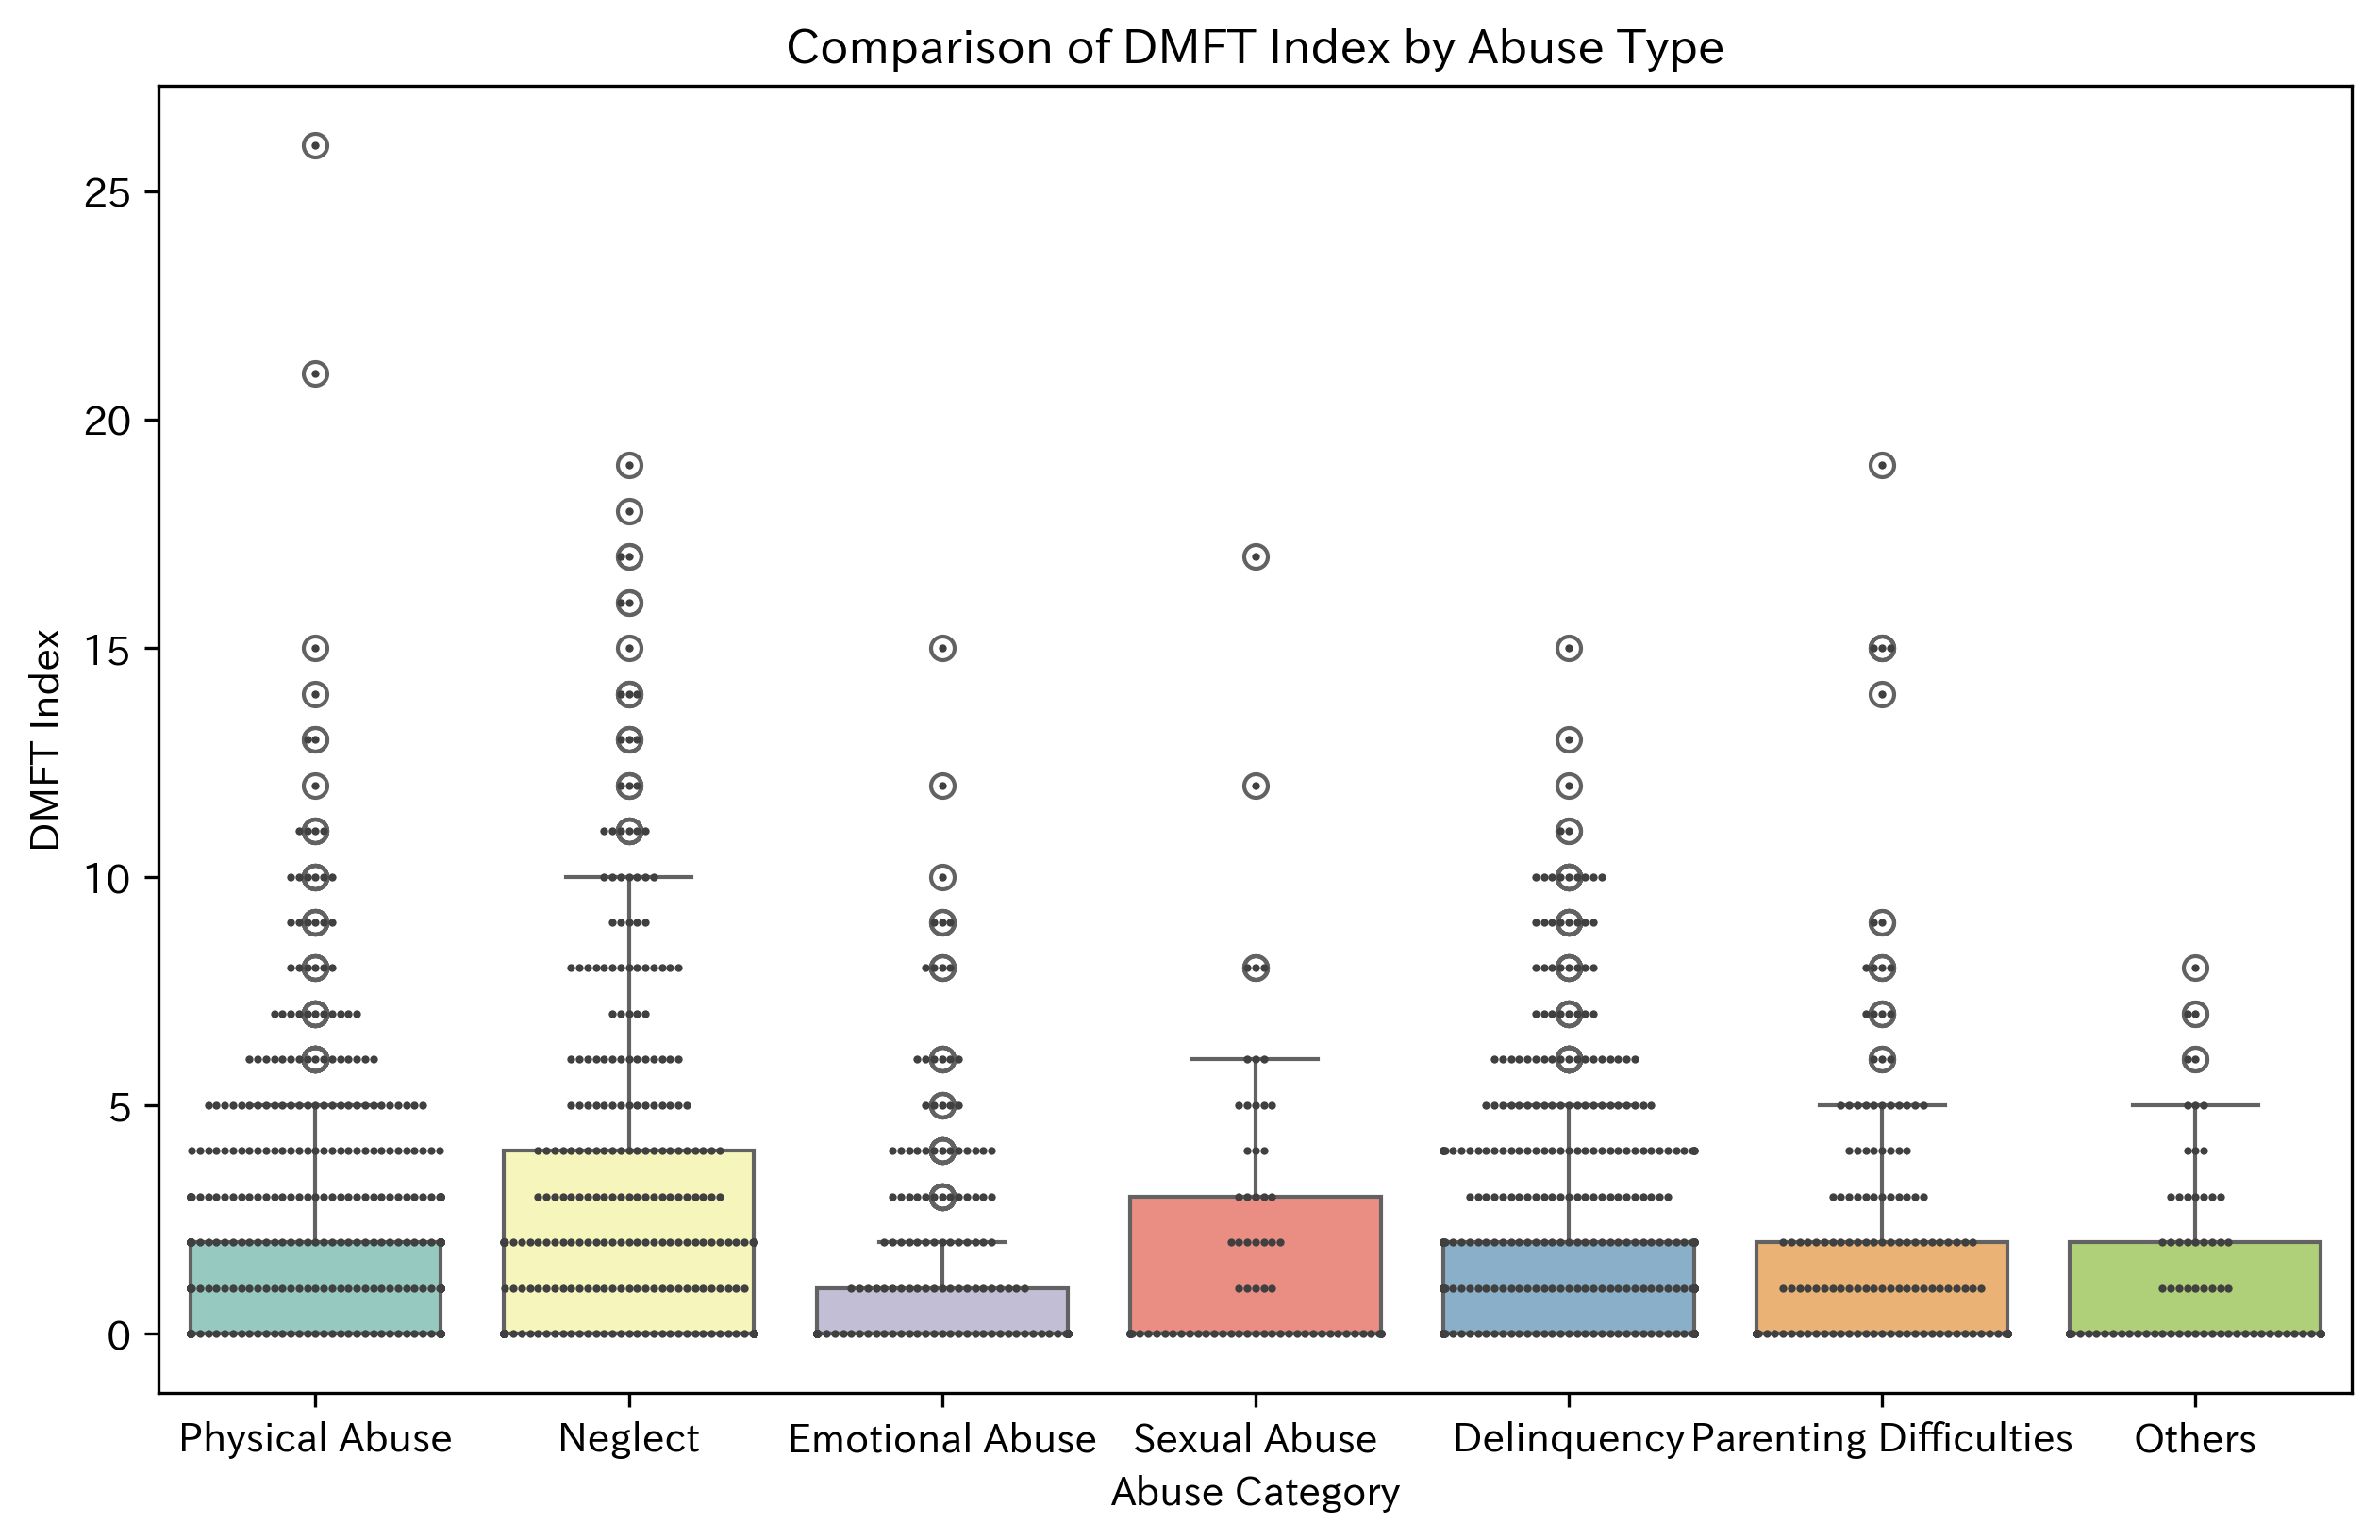

In [33]:
# 可視化
plt.figure(figsize=(10, 6),dpi=300)
sns.boxplot(x='abuse', y='DMFT_Index', data=df_final, palette="Set3")
sns.swarmplot(x='abuse', y='DMFT_Index', data=df_final, color=".25", size=2) # 分布の点を重ねる
plt.title('Comparison of DMFT Index by Abuse Type')
plt.xlabel('Abuse Category')
plt.ylabel('DMFT Index')
plt.show()

In [34]:
# 群間検定 (Kruskal-Wallis 検定)
# 各グループのデータをリストに格納
groups = [df_final[df_final['abuse'] == i]['DMFT_Index'] for i in df_final['abuse'].unique()]

# 検定実行
stat, p_value = stats.kruskal(*groups)

print(f"--- Kruskal-Wallis Test Results ---")
print(f"Statistic: {stat:.4f}")
print(f"P-value:   {p_value:.4e}")

if p_value < 0.05:
    print(">> 結果: 有意差あり (p < 0.05)。事後検定を行います。")
    
    # ==========================================
    # 4. 事後検定 (Dunn's Test with Bonferroni correction)
    # ==========================================
    # どの群間に差があるかを特定します
    # p_adjust='bonferroni' (ボンフェローニ補正) または 'holm' (ホルム補正) を推奨
    dunn_results = sp.posthoc_dunn(df_final, val_col='DMFT_Index', group_col='abuse', p_adjust='bonferroni')
    
    print("\n--- Dunn's Post-hoc Test (P-values) ---")
    print(dunn_results)
    
    # 見やすく判定を出力 (0.05以下ならTrue)
    print("\n--- Significant Differences (p < 0.05) ---")
    print(dunn_results < 0.05)
    
else:
    print(">> 結果: 有意差なし (p >= 0.05)。群間に統計的な差は見られませんでした。")

--- Kruskal-Wallis Test Results ---
Statistic: nan
P-value:   nan
>> 結果: 有意差なし (p >= 0.05)。群間に統計的な差は見られませんでした。


In [35]:
# グループごとの件数とDMFT平均値を確認
result_df = df_final.groupby('abuse')['DMFT_Index'].agg(['count', 'mean', 'median', 'std'])
# result_df.to_csv("/Users/yining/Desktop/_GSAIS_/Research/OralHealth_tokyo/paper_analysis/result/mean_median_result_each_abuse.csv")
print(result_df)


                        count      mean  median       std
abuse                                                    
Physical Abuse            777  1.413127     0.0  2.652169
Neglect                   406  2.440887     0.0  3.758145
Emotional Abuse           250  1.192000     0.0  2.334295
Sexual Abuse               77  1.844156     0.0  3.082484
Delinquency               602  1.571429     0.0  2.581590
Parenting Difficulties    263  1.406844     0.0  2.807751
Others                     99  1.101010     0.0  1.876248


/var/folders/nc/3dnb813d3ld83hg56j5wbw2w0000gn/T/ipykernel_81450/2117854408.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = df_final.groupby('abuse')['DMFT_Index'].agg(['count', 'mean', 'median', 'std'])


## Pre-COVID, COVID, After-COVIDの比較

### 一時保護児全員

In [63]:
# Convert date column to datetime
df_final['date'] = pd.to_datetime(df_final['date'])

# Create Period column based on date
def get_period(date):
    year = date.year
    if 2017 <= year <= 2019:
        return 'Pre-COVID'
    elif 2020 <= year <= 2022:
        return 'COVID'
    elif 2023 <= year <= 2025:
        return 'After COVID'
    else:
        return None

df_final['Period'] = df_final['date'].apply(get_period)

# Filter data for the defined periods
df_period = df_final.dropna(subset=['Period']).copy()
period_order = ['Pre-COVID', 'COVID', 'After COVID']

# Display sample counts per period
print(f"Data counts per period:\n{df_period['Period'].value_counts()}")

# Display descriptive statistics by period
print("\n--- Descriptive Statistics by Period ---")
print(df_period.groupby('Period')['DFT_Index'].describe())

Data counts per period:
Period
COVID          923
After COVID    829
Pre-COVID      695
Name: count, dtype: int64

--- Descriptive Statistics by Period ---
             count      mean       std  min  25%  50%  75%   max
Period                                                          
After COVID  829.0  1.322075  2.671871  0.0  0.0  0.0  2.0  26.0
COVID        923.0  1.630553  2.933651  0.0  0.0  0.0  2.0  19.0
Pre-COVID    695.0  1.791367  2.844366  0.0  0.0  0.0  3.0  18.0


In [47]:
from itertools import combinations
import scipy.stats as stats

# Define pairs
pairs = list(combinations(period_order, 2))

print("\n" + "=" * 100)
print(f"{'COMPARISON':<30} | {'MEDIANS (Group1 vs Group2)':<25} | {'P-VALUE':<12} | {'CONCLUSION'}")
print("=" * 100)

for period1, period2 in pairs:
    # Get data for each group
    group1 = df_period[df_period['Period'] == period1]['DFT_Index'].dropna()
    group2 = df_period[df_period['Period'] == period2]['DFT_Index'].dropna()
    
    # 1. Calculate Statistics (Median & Mean)
    median1, median2 = group1.median(), group2.median()
    mean1, mean2 = group1.mean(), group2.mean()
    
    # 2. Perform Mann-Whitney U Test
    statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    
    # 3. Determine Significance Symbol
    if p_value < 0.001: sig = '***'
    elif p_value < 0.01: sig = '**'
    elif p_value < 0.05: sig = '*'
    else: sig = 'ns'
    
    # 4. Determine Direction (Logic: If significant, which one is lower?)
    conclusion = "No significant difference"
    if p_value < 0.05:
        # Primary check: Compare Medians
        if median1 < median2:
            conclusion = f"{period1} is LOWER (Median: {median1} < {median2})"
        elif median1 > median2:
            conclusion = f"{period1} is HIGHER (Median: {median1} > {median2})"
        else:
            # Secondary check: If medians are equal, compare Means
            if mean1 < mean2:
                conclusion = f"{period1} is LOWER (Mean: {mean1:.2f} < {mean2:.2f})"
            else:
                conclusion = f"{period1} is HIGHER (Mean: {mean1:.2f} > {mean2:.2f})"

    # 5. Print Formatted Result
    medians_str = f"{median1} vs {median2}"
    p_str = f"{p_value:.4f} {sig}"
    pair_str = f"{period1} vs {period2}"
    
    print(f"{pair_str:<30} | {medians_str:<25} | {p_str:<12} | {conclusion}")


COMPARISON                     | MEDIANS (Group1 vs Group2) | P-VALUE      | CONCLUSION
Pre-COVID vs COVID             | 0.0 vs 0.0                | 0.0124 *     | Pre-COVID is HIGHER (Mean: 1.79 > 1.63)
Pre-COVID vs After COVID       | 0.0 vs 0.0                | 0.0000 ***   | Pre-COVID is HIGHER (Mean: 1.79 > 1.32)
COVID vs After COVID           | 0.0 vs 0.0                | 0.0449 *     | COVID is HIGHER (Mean: 1.63 > 1.32)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pre-COVID vs. COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:1.238e-02 U_stat=3.417e+05
COVID vs. After COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:4.489e-02 U_stat=4.010e+05
Pre-COVID vs. After COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:1.054e-05 U_stat=3.216e+05


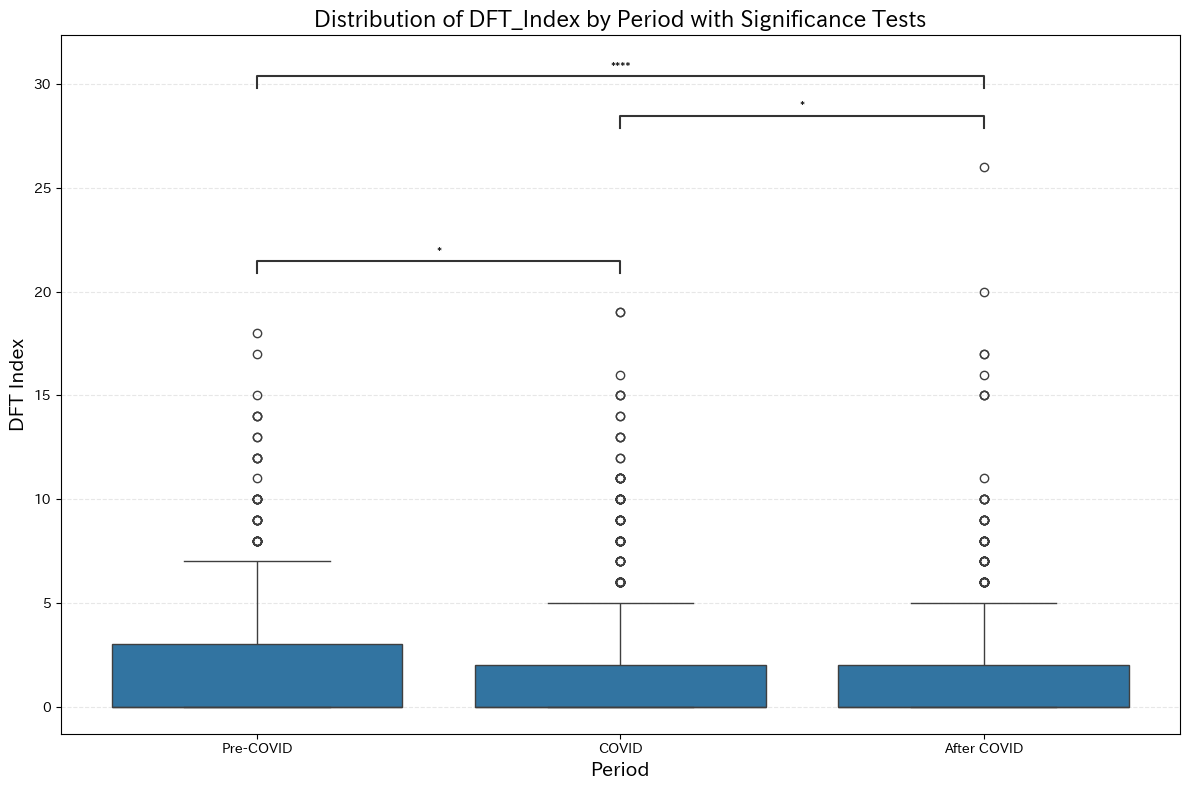

In [ ]:
# Install with: pip install statannotations

from statannotations.Annotator import Annotator

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_period, x='Period', y='DFT_Index', order=period_order, ax=ax)

# Define pairs for comparison
pairs = [
    ('Pre-COVID', 'COVID'),
    ('COVID', 'After COVID'),
    ('Pre-COVID', 'After COVID')
]

# Create annotator
annotator = Annotator(ax, pairs, data=df_period, x='Period', y='DFT_Index', order=period_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

# Customize the plot
ax.set_title('Distribution of DFT_Index by Period with Significance Tests', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('DFT Index', fontsize=14)
ax.set_xlabel('Period', fontsize=14)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 小学生、一時保護児全員

Original data: 2447 rows
Filtered data (age 7-12): 976 rows

Data counts per period (age 7-12 only):
Period
COVID          408
After COVID    352
Pre-COVID      216
Name: count, dtype: int64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pre-COVID vs. COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:3.743e-01 U_stat=4.581e+04
COVID vs. After COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:2.966e-02 U_stat=7.768e+04
Pre-COVID vs. After COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:6.277e-03 U_stat=4.267e+04


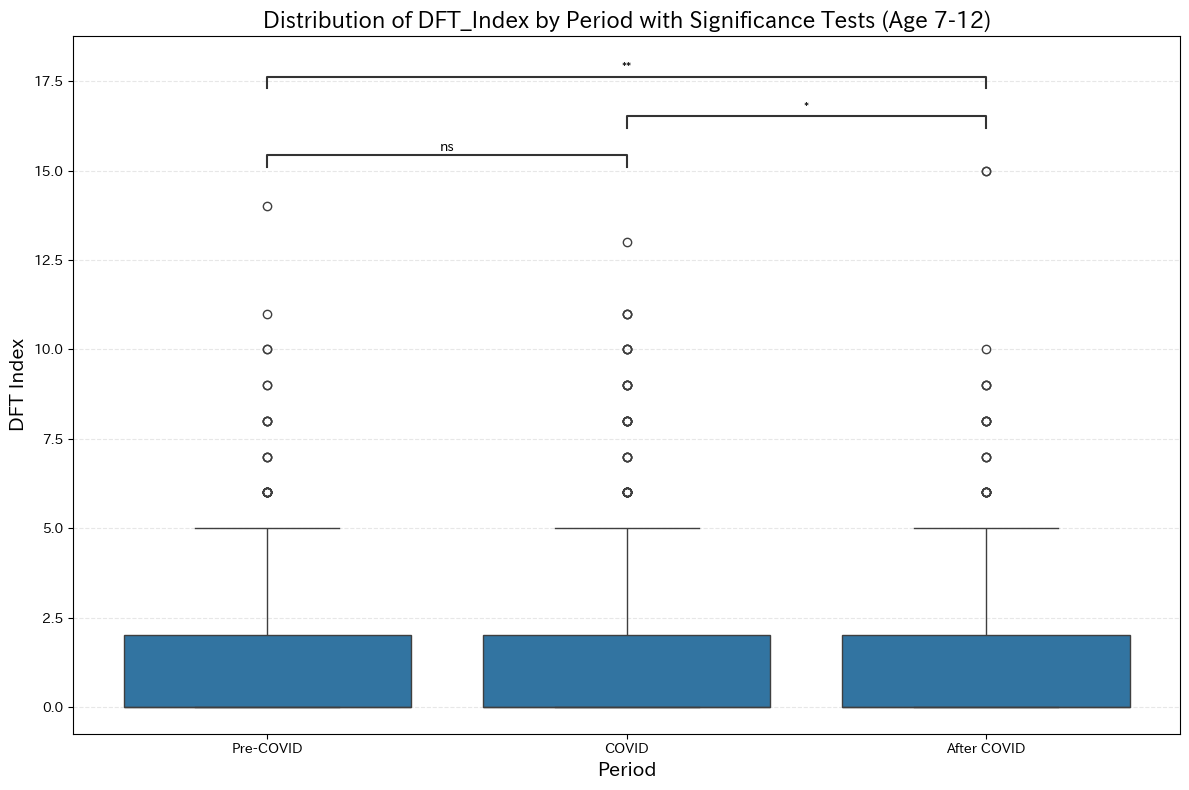

In [49]:
# Filter for age_year between 7 and 12
df_period_age_filtered = df_period[(df_period['age_year'] >= 7) & (df_period['age_year'] <= 12)]

print(f"Original data: {len(df_period)} rows")
print(f"Filtered data (age 7-12): {len(df_period_age_filtered)} rows")

# Check distribution by period after filtering
print(f"\nData counts per period (age 7-12 only):")
print(df_period_age_filtered['Period'].value_counts())

# Install with: pip install statannotations

from statannotations.Annotator import Annotator

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_period_age_filtered, x='Period', y='DFT_Index', order=period_order, ax=ax)

# Define pairs for comparison
pairs = [
    ('Pre-COVID', 'COVID'),
    ('COVID', 'After COVID'),
    ('Pre-COVID', 'After COVID')
]

# Create annotator
annotator = Annotator(ax, pairs, data=df_period_age_filtered, x='Period', y='DFT_Index', order=period_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

# Customize the plot
ax.set_title('Distribution of DFT_Index by Period with Significance Tests (Age 7-12)', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('DFT Index', fontsize=14)
ax.set_xlabel('Period', fontsize=14)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [50]:
# Define pairs
pairs = list(combinations(period_order, 2))

print("\n" + "=" * 100)
print(f"{'COMPARISON':<30} | {'MEDIANS (Group1 vs Group2)':<25} | {'P-VALUE':<12} | {'CONCLUSION'}")
print("=" * 100)

for period1, period2 in pairs:
    # Get data for each group
    group1 = df_period_age_filtered[df_period_age_filtered['Period'] == period1]['DFT_Index'].dropna()
    group2 = df_period_age_filtered[df_period_age_filtered['Period'] == period2]['DFT_Index'].dropna()
    
    # 1. Calculate Statistics (Median & Mean)
    median1, median2 = group1.median(), group2.median()
    mean1, mean2 = group1.mean(), group2.mean()
    
    # 2. Perform Mann-Whitney U Test
    statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    
    # 3. Determine Significance Symbol
    if p_value < 0.001: sig = '***'
    elif p_value < 0.01: sig = '**'
    elif p_value < 0.05: sig = '*'
    else: sig = 'ns'
    
    # 4. Determine Direction (Logic: If significant, which one is lower?)
    conclusion = "No significant difference"
    if p_value < 0.05:
        # Primary check: Compare Medians
        if median1 < median2:
            conclusion = f"{period1} is LOWER (Median: {median1} < {median2})"
        elif median1 > median2:
            conclusion = f"{period1} is HIGHER (Median: {median1} > {median2})"
        else:
            # Secondary check: If medians are equal, compare Means
            if mean1 < mean2:
                conclusion = f"{period1} is LOWER (Mean: {mean1:.2f} < {mean2:.2f})"
            else:
                conclusion = f"{period1} is HIGHER (Mean: {mean1:.2f} > {mean2:.2f})"

    # 5. Print Formatted Result
    medians_str = f"{median1} vs {median2}"
    p_str = f"{p_value:.4f} {sig}"
    pair_str = f"{period1} vs {period2}"
    
    print(f"{pair_str:<30} | {medians_str:<25} | {p_str:<12} | {conclusion}")


COMPARISON                     | MEDIANS (Group1 vs Group2) | P-VALUE      | CONCLUSION
Pre-COVID vs COVID             | 0.0 vs 0.0                | 0.3743 ns    | No significant difference
Pre-COVID vs After COVID       | 0.0 vs 0.0                | 0.0063 **    | Pre-COVID is HIGHER (Mean: 1.70 > 1.24)
COVID vs After COVID           | 0.0 vs 0.0                | 0.0297 *     | COVID is HIGHER (Mean: 1.59 > 1.24)


### 小学生、虐待児全員

In [54]:
df_period['abuse'].unique()

['Delinquency', 'Physical Abuse', 'Others', 'Neglect', 'Parenting Difficulties', 'Emotional Abuse', 'Sexual Abuse', NaN]
Categories (7, object): ['Physical Abuse' < 'Neglect' < 'Emotional Abuse' < 'Sexual Abuse' < 'Delinquency' < 'Parenting Difficulties' < 'Others']


Abuse type distribution:
abuse
Physical Abuse            386
Neglect                   158
Emotional Abuse            98
Sexual Abuse               35
Delinquency                 0
Parenting Difficulties      0
Others                      0
Name: count, dtype: int64
小学生 data: 976 rows
小学生虐待児データ: 677 rows

Data counts per period (age 7-12 only):
Period
COVID          289
After COVID    247
Pre-COVID      141
Name: count, dtype: int64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pre-COVID vs. COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:9.674e-01 U_stat=2.042e+04
COVID vs. After COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:3.276e-02 U_stat=3.911e+04
Pre-COVID vs. After COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:6.476e-02 U_stat=1.916e+04


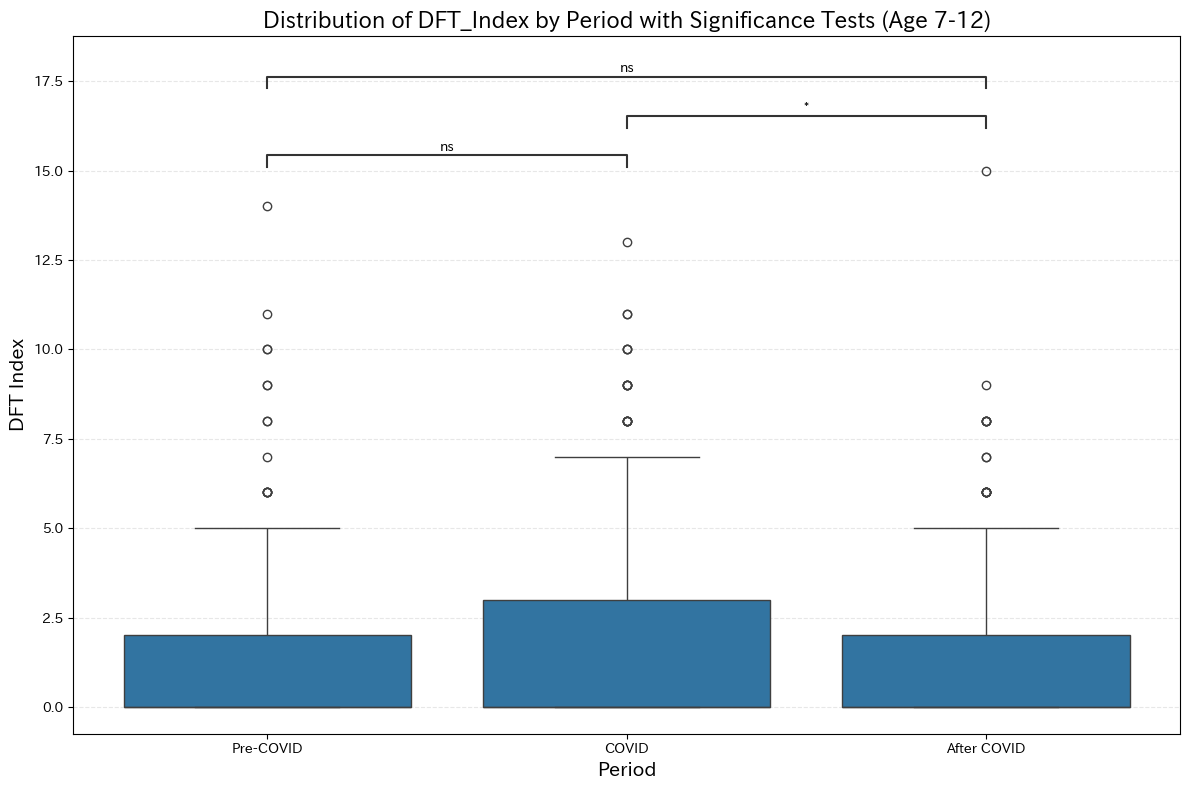

In [57]:
# Filter for age_year between 7 and 12
df_period_age_filtered = df_period[(df_period['age_year'] >= 7) & (df_period['age_year'] <= 12)]
df_period_abuse = df_period_age_filtered[df_period_age_filtered['abuse'].isin(["Physical Abuse", "Neglect", "Emotional Abuse", "Sexual Abuse"])]

# Verify the result
print(f"\nAbuse type distribution:")
print(df_period_abuse['abuse'].value_counts())

print(f"小学生 data: {len(df_period_age_filtered)} rows")
print(f"小学生虐待児データ: {len(df_period_abuse)} rows")

# Check distribution by period after filtering
print(f"\nData counts per period (age 7-12 only):")
print(df_period_abuse['Period'].value_counts())

# Install with: pip install statannotations

from statannotations.Annotator import Annotator

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_period_abuse, x='Period', y='DFT_Index', order=period_order, ax=ax)

# Define pairs for comparison
pairs = [
    ('Pre-COVID', 'COVID'),
    ('COVID', 'After COVID'),
    ('Pre-COVID', 'After COVID')
]

# Create annotator
annotator = Annotator(ax, pairs, data=df_period_abuse, x='Period', y='DFT_Index', order=period_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

# Customize the plot
ax.set_title('Distribution of DFT_Index by Period with Significance Tests (Age 7-12)', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('DFT Index', fontsize=14)
ax.set_xlabel('Period', fontsize=14)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [58]:
# Define pairs
pairs = list(combinations(period_order, 2))

print("\n" + "=" * 100)
print(f"{'COMPARISON':<30} | {'MEDIANS (Group1 vs Group2)':<25} | {'P-VALUE':<12} | {'CONCLUSION'}")
print("=" * 100)

for period1, period2 in pairs:
    # Get data for each group
    group1 = df_period_abuse[df_period_abuse['Period'] == period1]['DFT_Index'].dropna()
    group2 = df_period_abuse[df_period_abuse['Period'] == period2]['DFT_Index'].dropna()
    
    # 1. Calculate Statistics (Median & Mean)
    median1, median2 = group1.median(), group2.median()
    mean1, mean2 = group1.mean(), group2.mean()
    
    # 2. Perform Mann-Whitney U Test
    statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    
    # 3. Determine Significance Symbol
    if p_value < 0.001: sig = '***'
    elif p_value < 0.01: sig = '**'
    elif p_value < 0.05: sig = '*'
    else: sig = 'ns'
    
    # 4. Determine Direction (Logic: If significant, which one is lower?)
    conclusion = "No significant difference"
    if p_value < 0.05:
        # Primary check: Compare Medians
        if median1 < median2:
            conclusion = f"{period1} is LOWER (Median: {median1} < {median2})"
        elif median1 > median2:
            conclusion = f"{period1} is HIGHER (Median: {median1} > {median2})"
        else:
            # Secondary check: If medians are equal, compare Means
            if mean1 < mean2:
                conclusion = f"{period1} is LOWER (Mean: {mean1:.2f} < {mean2:.2f})"
            else:
                conclusion = f"{period1} is HIGHER (Mean: {mean1:.2f} > {mean2:.2f})"

    # 5. Print Formatted Result
    medians_str = f"{median1} vs {median2}"
    p_str = f"{p_value:.4f} {sig}"
    pair_str = f"{period1} vs {period2}"
    
    print(f"{pair_str:<30} | {medians_str:<25} | {p_str:<12} | {conclusion}")


COMPARISON                     | MEDIANS (Group1 vs Group2) | P-VALUE      | CONCLUSION
Pre-COVID vs COVID             | 0.0 vs 0.0                | 0.9674 ns    | No significant difference
Pre-COVID vs After COVID       | 0.0 vs 0.0                | 0.0648 ns    | No significant difference
COVID vs After COVID           | 0.0 vs 0.0                | 0.0328 *     | COVID is HIGHER (Mean: 1.72 > 1.29)


### 虐待児全員


Abuse type distribution:
abuse
Physical Abuse            768
Neglect                   401
Emotional Abuse           247
Sexual Abuse               77
Delinquency                 0
Parenting Difficulties      0
Others                      0
Name: count, dtype: int64
Original data: 2447 rows
虐待児データ: 1493 rows

Data counts per period (age 7-12 only):
Period
COVID          596
After COVID    492
Pre-COVID      405
Name: count, dtype: int64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pre-COVID vs. COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:8.687e-02 U_stat=1.276e+05
COVID vs. After COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:1.644e-01 U_stat=1.529e+05
Pre-COVID vs. After COVID: Mann-Whitney-Wilcoxon test two-sided, P_val:3.263e-03 U_stat=1.097e+05


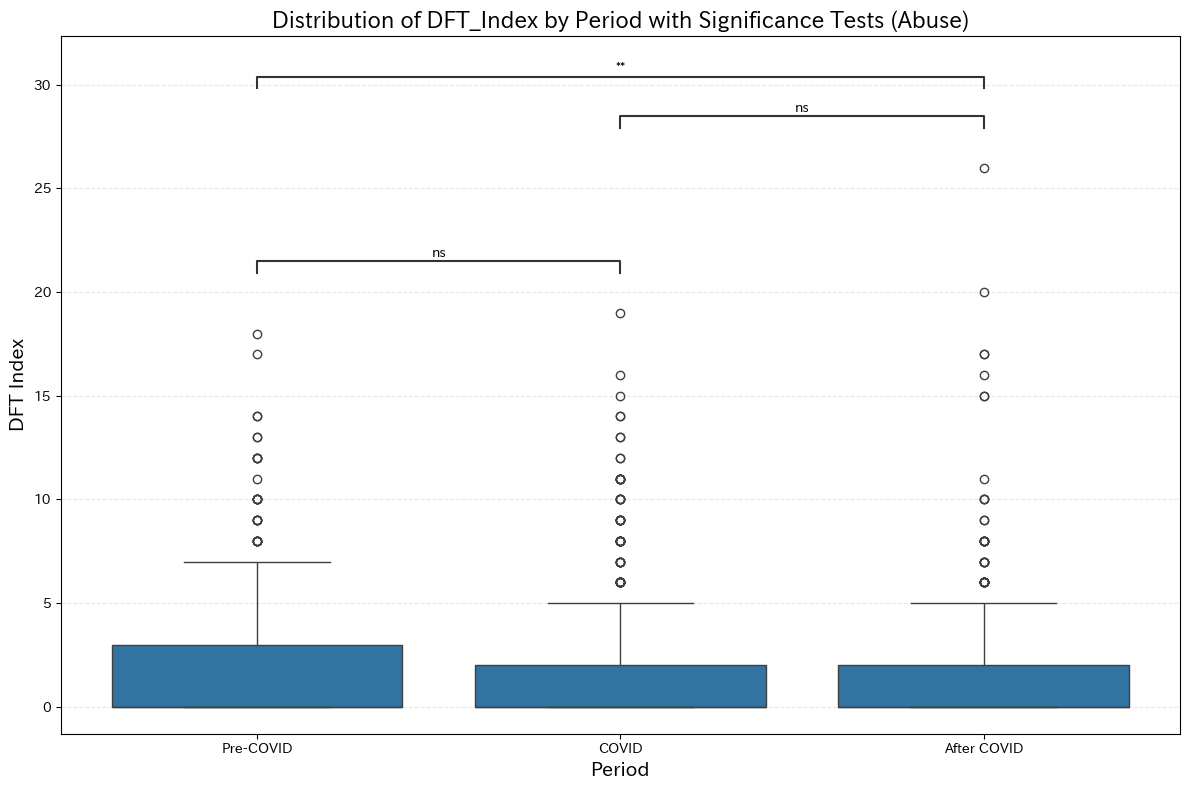

In [62]:
# Filter for age_year between 7 and 12
df_period_abuse = df_period[df_period['abuse'].isin(["Physical Abuse", "Neglect", "Emotional Abuse", "Sexual Abuse"])]

# Verify the result
print(f"\nAbuse type distribution:")
print(df_period_abuse['abuse'].value_counts())

print(f"Original data: {len(df_period)} rows")
print(f"虐待児データ: {len(df_period_abuse)} rows")

# Check distribution by period after filtering
print(f"\nData counts per period (age 7-12 only):")
print(df_period_abuse['Period'].value_counts())

# Install with: pip install statannotations

from statannotations.Annotator import Annotator

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_period_abuse, x='Period', y='DFT_Index', order=period_order, ax=ax)

# Define pairs for comparison
pairs = [
    ('Pre-COVID', 'COVID'),
    ('COVID', 'After COVID'),
    ('Pre-COVID', 'After COVID')
]

# Create annotator
annotator = Annotator(ax, pairs, data=df_period_abuse, x='Period', y='DFT_Index', order=period_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

# Customize the plot
ax.set_title('Distribution of DFT_Index by Period with Significance Tests (Abuse)', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('DFT Index', fontsize=14)
ax.set_xlabel('Period', fontsize=14)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [60]:
# Define pairs
pairs = list(combinations(period_order, 2))

print("\n" + "=" * 100)
print(f"{'COMPARISON':<30} | {'MEDIANS (Group1 vs Group2)':<25} | {'P-VALUE':<12} | {'CONCLUSION'}")
print("=" * 100)

for period1, period2 in pairs:
    # Get data for each group
    group1 = df_period_abuse[df_period_abuse['Period'] == period1]['DFT_Index'].dropna()
    group2 = df_period_abuse[df_period_abuse['Period'] == period2]['DFT_Index'].dropna()
    
    # 1. Calculate Statistics (Median & Mean)
    median1, median2 = group1.median(), group2.median()
    mean1, mean2 = group1.mean(), group2.mean()
    
    # 2. Perform Mann-Whitney U Test
    statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    
    # 3. Determine Significance Symbol
    if p_value < 0.001: sig = '***'
    elif p_value < 0.01: sig = '**'
    elif p_value < 0.05: sig = '*'
    else: sig = 'ns'
    
    # 4. Determine Direction (Logic: If significant, which one is lower?)
    conclusion = "No significant difference"
    if p_value < 0.05:
        # Primary check: Compare Medians
        if median1 < median2:
            conclusion = f"{period1} is LOWER (Median: {median1} < {median2})"
        elif median1 > median2:
            conclusion = f"{period1} is HIGHER (Median: {median1} > {median2})"
        else:
            # Secondary check: If medians are equal, compare Means
            if mean1 < mean2:
                conclusion = f"{period1} is LOWER (Mean: {mean1:.2f} < {mean2:.2f})"
            else:
                conclusion = f"{period1} is HIGHER (Mean: {mean1:.2f} > {mean2:.2f})"

    # 5. Print Formatted Result
    medians_str = f"{median1} vs {median2}"
    p_str = f"{p_value:.4f} {sig}"
    pair_str = f"{period1} vs {period2}"
    
    print(f"{pair_str:<30} | {medians_str:<25} | {p_str:<12} | {conclusion}")


COMPARISON                     | MEDIANS (Group1 vs Group2) | P-VALUE      | CONCLUSION
Pre-COVID vs COVID             | 0.0 vs 0.0                | 0.0869 ns    | No significant difference
Pre-COVID vs After COVID       | 0.0 vs 0.0                | 0.0033 **    | Pre-COVID is HIGHER (Mean: 1.89 > 1.44)
COVID vs After COVID           | 0.0 vs 0.0                | 0.1644 ns    | No significant difference
